# Setup 

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import date_format
from pyspark.sql.functions import avg
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format
from pyspark.sql.functions import count
from pyspark.ml.feature import Word2Vec, PCA, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StringType
from itertools import chain
import matplotlib.pyplot as plt

In [4]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )\
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-340edd02-d36e-45b0-86e9-7e73e8eeafc2;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 323ms :: artifacts dl 19ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

In [5]:
print(f"Spark version: {spark.version}")
print(f"sparknlp version: {sparknlp.version()}")

Spark version: 3.4.0
sparknlp version: 5.1.3


In [6]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
print(bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker-us-east-1-433974840707


# Read in Submissions Data

In [31]:
# S3 directory path
s3_directory_subs = f"s3a://{bucket}/project/nlp_cleaned_submissions/"

# Read all the Parquet files in the directory into a DataFrame
submissions_cleaned = spark.read.parquet(s3_directory_subs)

In [8]:
print("Number of records for all subreddit submissions:", submissions_cleaned.count())

Number of records for all subreddit submissions: 599908


In [11]:
submissions_cleaned.columns

['author',
 'title',
 'selftext',
 'subreddit',
 'score',
 'num_comments',
 'permalink',
 'created_utc',
 'url',
 'domain',
 'is_video',
 'is_self',
 'is_reddit_media_domain',
 'spoiler',
 'over_18',
 'stickied',
 'thumbnail',
 'media',
 'secure_media',
 'gilded',
 'archived',
 'distinguished',
 'cleaned_body',
 'cleaned_title']

In [10]:
submissions_cleaned.show(5)

+--------------------+--------------------+--------------------+---------+-----+------------+--------------------+-----------+--------------------+------------------+--------+-------+----------------------+-------+-------+--------+--------------------+--------------------+--------------------+------+--------+-------------+--------------------+--------------------+
|              author|               title|            selftext|subreddit|score|num_comments|           permalink|created_utc|                 url|            domain|is_video|is_self|is_reddit_media_domain|spoiler|over_18|stickied|           thumbnail|               media|        secure_media|gilded|archived|distinguished|        cleaned_body|       cleaned_title|
+--------------------+--------------------+--------------------+---------+-----+------------+--------------------+-----------+--------------------+------------------+--------+-------+----------------------+-------+-------+--------+--------------------+--------------

In [9]:
submissions_cleaned.printSchema()

root
 |-- distinguished: string (nullable = false)
 |-- subreddit: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- cleaned_body: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- spoiler: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)



In [32]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

submissions_cleaned = submissions_cleaned.withColumn('year', F.year('created_utc')) \
                                         .withColumn('month', F.month('created_utc')) \
                                         .withColumn ('day', F.dayofmonth("created_utc")) \
                                         .withColumn('distinguished', F.when(submissions_cleaned['distinguished'] == 'moderator', 'yes')
                                                     .otherwise(submissions_cleaned['distinguished'])) \
                                         .withColumn('is_video', F.col('is_video').cast("string")) \
                                         .withColumn('spoiler', F.col('spoiler').cast("string")) \
                                         .withColumn('over_18', F.col('over_18').cast("string")) \
                                         .withColumn('num_comments', F.col('num_comments').cast(IntegerType()))

submissions_cleaned = submissions_cleaned.fillna({'distinguished': "no"})

# select required cols for clustering

submissions_cleaned = submissions_cleaned.select("distinguished", "subreddit", "year", "month", "day", "num_comments", "score", "over_18", "cleaned_body", "spoiler", "is_video", "gilded")

# Create Word2Vec embeddings of `cleaned_body`

In [33]:
### WORD2VEC ###

from pyspark.ml.feature import Tokenizer, Word2Vec

# Step 3: Create and Train Word2Vec Model
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="cleaned_body", outputCol="embeddings")
model = word2Vec.fit(submissions_cleaned)

# Step 4: Transform the Data
df_with_embeddings = model.transform(submissions_cleaned)

In [34]:
df_with_embeddings.columns

['distinguished',
 'subreddit',
 'year',
 'month',
 'day',
 'num_comments',
 'score',
 'over_18',
 'cleaned_body',
 'spoiler',
 'is_video',
 'gilded',
 'embeddings']

## Create Pipeline

In [35]:
subreddit_col = df_with_embeddings.select("subreddit")
subreddit_col_pd = subreddit_col.toPandas()

In [36]:
cols_to_select = df_with_embeddings.columns
cols_to_select.remove("subreddit")

# Select all columns except "subreddit"
pca_df = df_with_embeddings.select(*[col(col_name) for col_name in cols_to_select])

In [37]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

distinguished_indexer = StringIndexer(inputCol="distinguished", outputCol="distinguished_ix")
#subreddit_indexer = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")
video_indexer = StringIndexer(inputCol="is_video", outputCol="is_video_index")
spoiler_indexer = StringIndexer(inputCol="spoiler", outputCol="spoiler_index")
over_18_indexer = StringIndexer(inputCol="over_18", outputCol="over_18_index")

#subreddit_encoder = OneHotEncoder(inputCol="subreddit_ix", outputCol="subreddit_vec")

pipeline = Pipeline(stages=[distinguished_indexer, video_indexer, spoiler_indexer, over_18_indexer])

pca_df_encoded = pipeline.fit(pca_df).transform(pca_df)

In [38]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

vectorAssembler_features = VectorAssembler(inputCols=['distinguished_ix', 'year', 'month', 'day', 'score', 'gilded', "num_comments", "score", "over_18_index", "spoiler_index", "is_video_index"],
                                           outputCol= 'features')

scaler = StandardScaler(
                    inputCol = 'features',
                    outputCol = 'scaledFeatures',
                    withMean = True,
                    withStd = True
         )

n_components = 2
pca = PCA(
            k = n_components,
            inputCol = 'scaledFeatures',
            outputCol = 'pcaFeatures'
        )


# Define the Pipeline
pipeline = Pipeline(stages=[vectorAssembler_features, scaler, pca])

# Fit and Transform pca_df_encoded using pipeline

pca_model = pipeline.fit(pca_df_encoded).transform(pca_df_encoded)

23/12/06 00:04:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


## PCA with 2 components to visualize raw data by subreddit on 2D plot

In [44]:
# save pca df in s3

pca_model.write.parquet(f"s3a://{bucket}/project/pca_subs/", mode='overwrite')

In [42]:
pca_model.columns

['distinguished',
 'year',
 'month',
 'day',
 'num_comments',
 'score',
 'over_18',
 'cleaned_body',
 'spoiler',
 'is_video',
 'gilded',
 'embeddings',
 'distinguished_ix',
 'is_video_index',
 'spoiler_index',
 'over_18_index',
 'features',
 'scaledFeatures',
 'pcaFeatures']

In [45]:
# not sure if this is the best way to do it
X_pca = pca_model.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [50]:
# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_pca(X_pca, y):
    """a scatter plot of the 2-dimensional submissions data"""
    markers = ['s', 'x', 'o', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'D']
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

In [51]:
plot_pca(X_pca, subreddit_col_pd)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1

In [53]:
subreddit_col_pd.shape

(599908, 1)

In [54]:
X_pca

array([[-0.29978992, -0.51705833],
       [-0.30828099,  0.3426218 ],
       [-0.31157503, -0.07915274],
       ...,
       [-0.33580681,  1.0316967 ],
       [-0.33292898, -0.0131314 ],
       [ 3.34573769,  1.12503749]])

In [55]:
subreddit_col_pd

,subreddit
0,socialism
1,socialism
2,Economics
3,Liberal
4,socialism
...,...
599903,Conservative
599904,Conservative
599905,Conservative
599906,finance


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


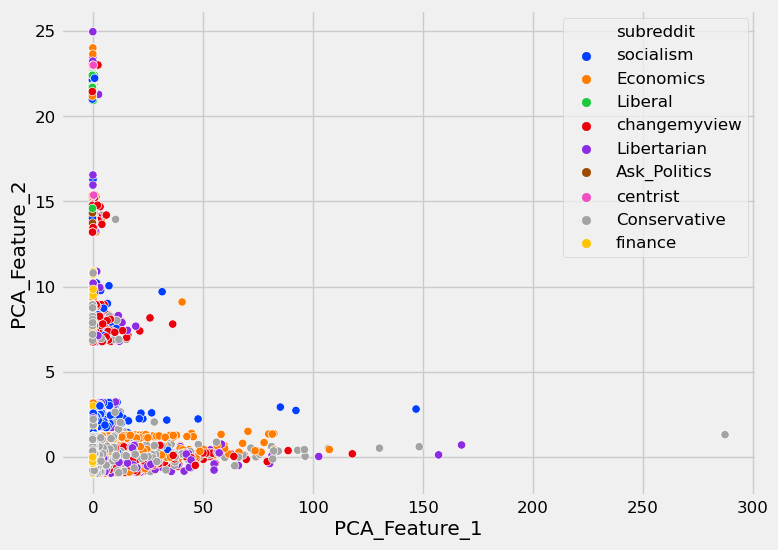

In [62]:
import seaborn as sns

# Concatenate the two DataFrames
result_df = pd.concat([subreddit_col_pd, pd.DataFrame(X_pca, columns=['PCA_Feature_1', 'PCA_Feature_2'])], axis=1)

# Plot using Seaborn
sns.scatterplot(x='PCA_Feature_1', y='PCA_Feature_2', hue='subreddit', data=result_df, palette='bright')
# save fig
plt.savefig("../../data/plots/pca_all_subreddits.png")
plt.savefig("../../website-source/pca_all_subreddits.png")
# Show the plot
plt.show()

In [59]:
result_df.to_csv("../../data/csv/pca_df.csv", index=False)

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


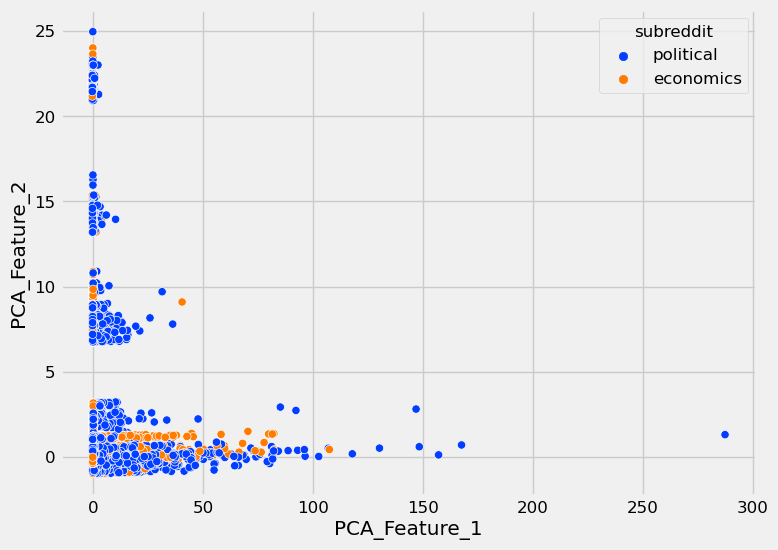

In [64]:
# Grouping subreddits as political or economics
result_df = pd.concat([subreddit_col_pd, pd.DataFrame(X_pca, columns=['PCA_Feature_1', 'PCA_Feature_2'])], axis=1)

def rename_subreddit(subreddit):
    if subreddit in ("Economics", "finance"):
        return "economics"
    else:
        return "political"

result_df["subreddit"] = result_df["subreddit"].apply(rename_subreddit)

# Plot using Seaborn with a categorical color palette
sns.scatterplot(x='PCA_Feature_1', y='PCA_Feature_2', hue='subreddit', data=result_df, palette='bright')

# Show the plot
plt.show()

## KMeans Clustering on PCA data (Locally)

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sklearn.cluster
from statistics import mode
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
sns.set_theme(style="whitegrid", palette='Set2')
import warnings
warnings.filterwarnings("ignore")

In [2]:
pca_df = pd.read_csv("../../data/csv/pca_df.csv")

In [3]:
pca_df.shape # get the number of rows and columns

(599908, 4)

In [4]:
pca_df.head()

,Unnamed: 0,subreddit,PCA_Feature_1,PCA_Feature_2
0,0,socialism,-0.299790,-0.517058
1,1,socialism,-0.308281,0.342622
2,2,Economics,-0.311575,-0.079153
3,3,Liberal,-0.281342,-0.429890
4,4,socialism,3.307645,-0.147045


In [5]:
pca_df.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
pca_df.head()

,subreddit,PCA_Feature_1,PCA_Feature_2
0,socialism,-0.299790,-0.517058
1,socialism,-0.308281,0.342622
2,Economics,-0.311575,-0.079153
3,Liberal,-0.281342,-0.429890
4,socialism,3.307645,-0.147045


In [7]:
# seperate the features from the target

X = pca_df.drop("subreddit", axis=1)
y = pca_df["subreddit"]

### Perform KMeans Clustering with all 9 subreddits

In [8]:
# for k means clustering we will use the elbow method to find the optimal number of clusters.
# we will use the inertia_ attribute to find the sum of squared distances of samples to their closest cluster center.
# we will use the range of 1 to 12 clusters and plot the inertia_ values for each cluster.
distortions = []
inertias = []
k = 12

for k in range(1,k):
    kmeansmodel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeansmodel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeansmodel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])
    inertias.append(kmeansmodel.inertia_)
    evaluation=pd.DataFrame.from_records({"Cluster":np.arange(1,k+1), "Distortion":distortions, "Inertia":inertias})

evaluation

,Cluster,Distortion,Inertia
0,1,0.806508,2.318779e+06
1,2,0.720983,1.608663e+06
2,3,0.661291,1.154088e+06
3,4,0.611819,7.414638e+05
4,5,0.576421,5.787194e+05
5,6,0.451568,4.715226e+05
6,7,0.431004,3.836171e+05
7,8,0.415867,3.163443e+05
8,9,0.407123,2.576952e+05
9,10,0.382387,2.146869e+05


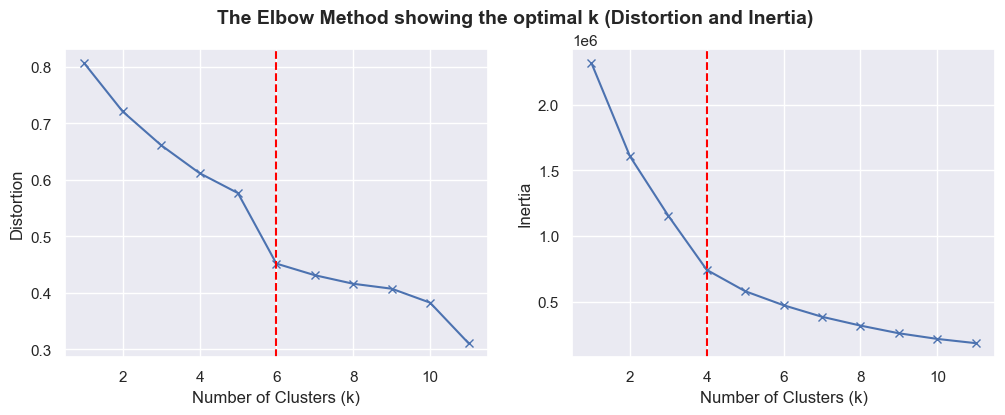

In [10]:
# plot distortion and inertia for kmeans
fig, ax = plt.subplots(1, 2)
# increase the size of the figure
fig.set_size_inches(12, 4)
# template theme
sns.set_theme(style="darkgrid")
ax[0].plot(evaluation.Cluster, evaluation.Distortion, 'bx-')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Distortion')
# vertical line to indicate the optimal number of clusters at 6 in figure 1
ax[0].axvline(x=6, linestyle='--', c='red')
ax[1].plot(evaluation.Cluster, evaluation.Inertia, 'bx-')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Inertia')
# vertical line to indicate the optimal number of clusters at 4
plt.axvline(x=4, linestyle='--', c='red')
fig.suptitle('The Elbow Method showing the optimal k (Distortion and Inertia)', fontsize=14, fontweight='bold')
plt.savefig("../../data/plots/elbow_method.png")
plt.show()

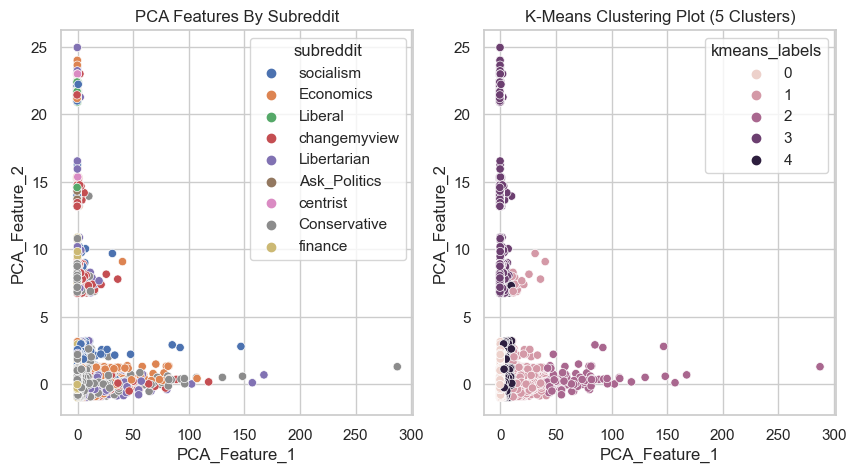

In [11]:
# Plotting clusters for best k = 5 (as per elbow method above)

bestK = KMeans(n_clusters=5, init='k-means++', random_state=42)
labels5 = bestK.fit_predict(X)
pca_df['kmeans_labels'] = labels5

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x="PCA_Feature_1", y="PCA_Feature_2", hue="subreddit", data=pca_df, ax=ax[0]).set(title='PCA Features By Subreddit')
sns.scatterplot(x="PCA_Feature_1", y="PCA_Feature_2", hue="kmeans_labels", data=pca_df, ax=ax[1]).set(title='K-Means Clustering Plot (5 Clusters)')
plt.savefig("../../data/plots/kmeans_clusters_elbow.png")
plt.savefig("../../website-source/kmeans_clusters_elbow.png")
plt.show()

### Hyperparameter Tuning Number of Clusters with Silhouette Score

Working on 4 clusters
Working on 5 clusters
Working on 6 clusters
Working on 7 clusters
Working on 8 clusters
Working on 9 clusters
Working on 10 clusters
OPTIMAL NUMBER OF CLUSTERS = 4


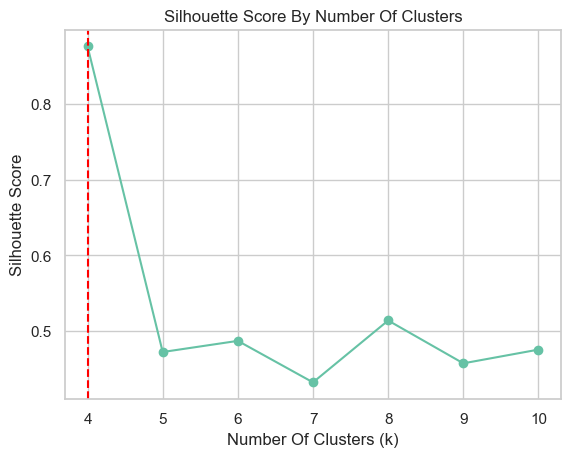

In [9]:
def maximize_silhouette(X,algo="birch",nmin=2, nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X)

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(nmin,nmax+1):
        if(algo=="kmeans"):
            print("Working on",param,"clusters")
            model = KMeans(n_clusters=param, init='random')
            labels=model.fit_predict(X)

        try:
            sil_scores.append(silhouette_score(X,labels))
            params.append(param)
        except:
            continue

        if(i_print): print(param,sil_scores[-1])

        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL NUMBER OF CLUSTERS =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")
        ax.set(xlabel='Number Of Clusters (k)', ylabel='Silhouette Score', title='Silhouette Score By Number Of Clusters')
        plt.axvline(x=opt_param, color='red', linestyle='--')
        #plt.text(opt_param+0.2, sil_max+0.01, 'k = %d' % opt_param)
        plt.savefig("../../data/plots/silhouette_score_tuning.png")
        plt.savefig("../../website-source/silhouette_score_tuning.png")
        plt.show()

    return opt_labels

k_means_opt_labels=maximize_silhouette(X,algo="kmeans",nmin=4, nmax=10, i_plot=True)

For n_clusters = 4 The average silhouette_score is : 0.8757106308706852
For n_clusters = 6 The average silhouette_score is : 0.48703280632198676
For n_clusters = 8 The average silhouette_score is : 0.49958818589536474
For n_clusters = 9 The average silhouette_score is : 0.5040308016434782


KeyboardInterrupt: 

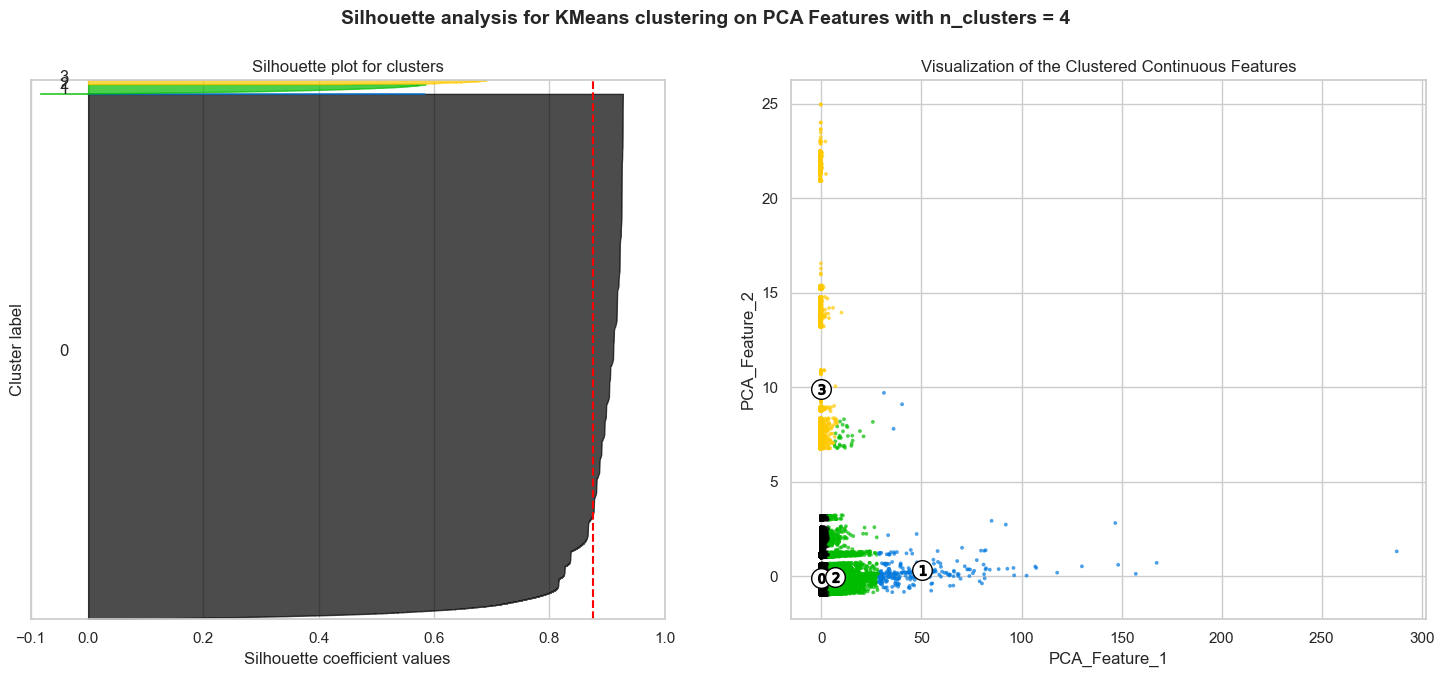

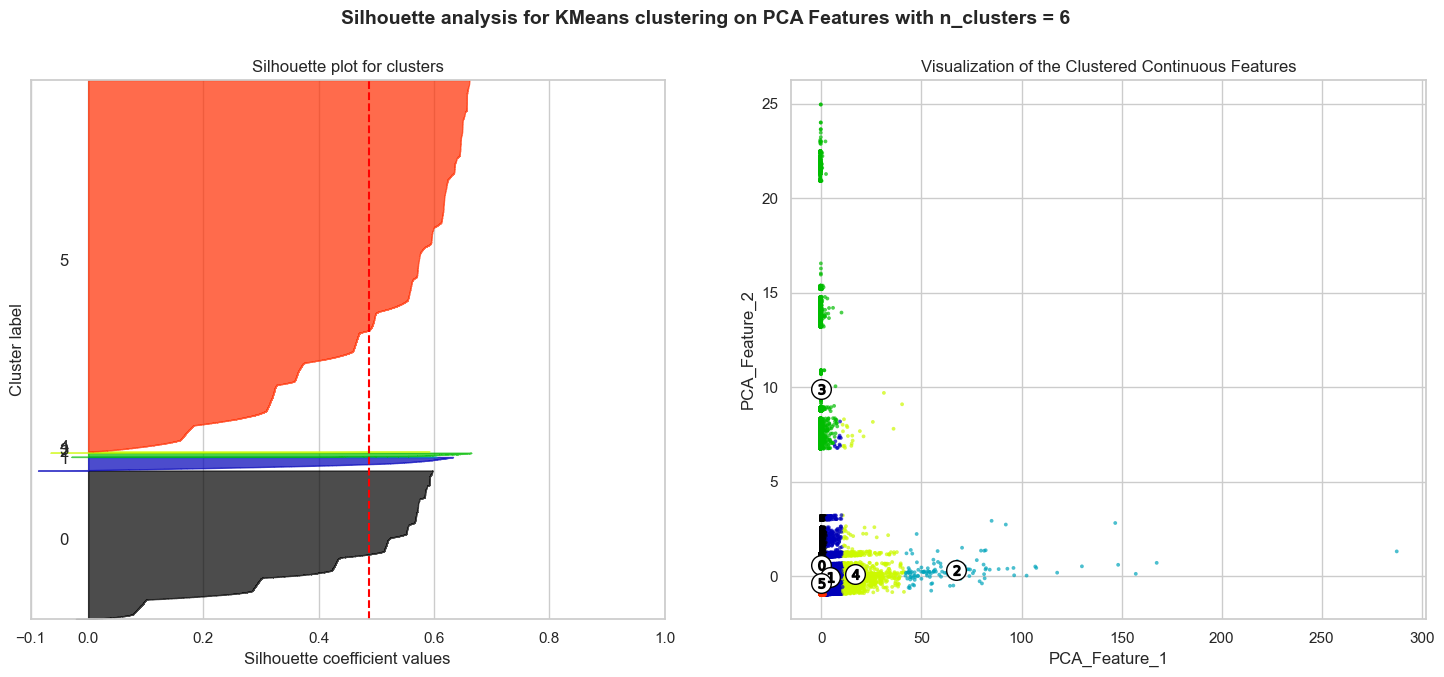

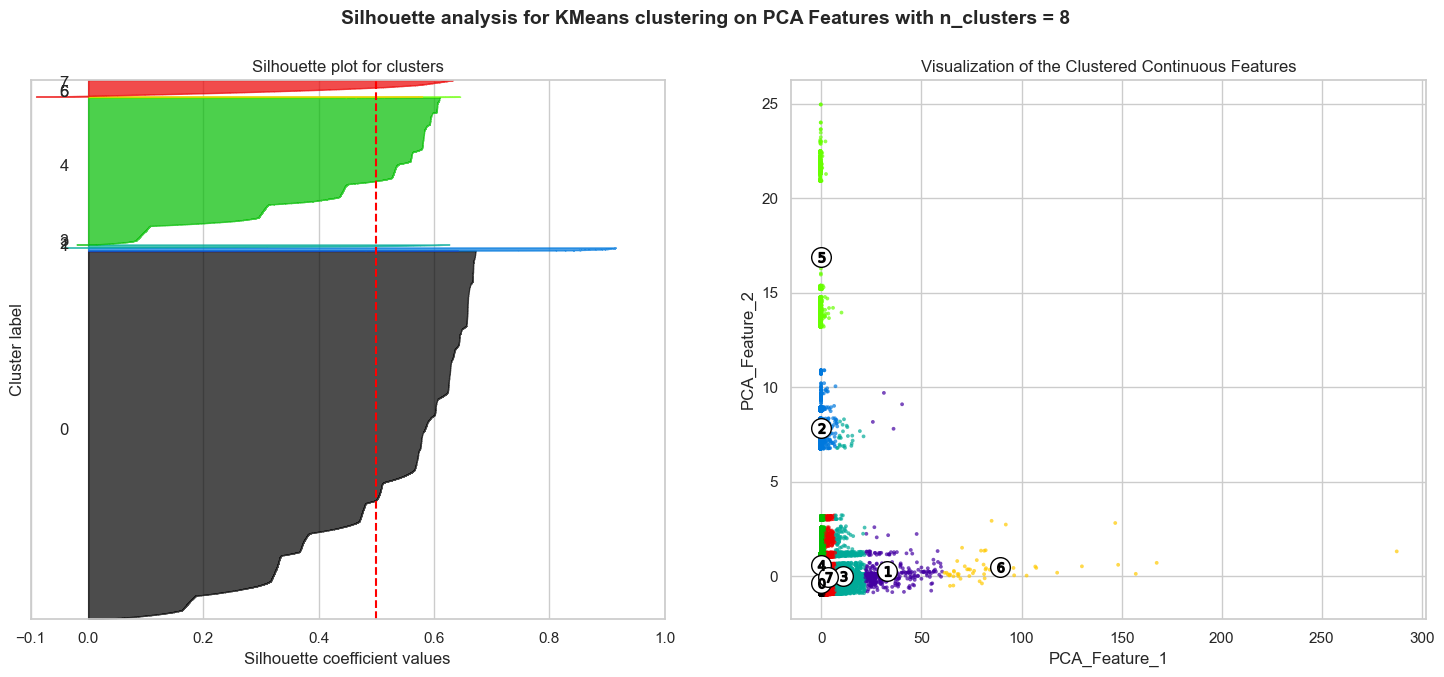

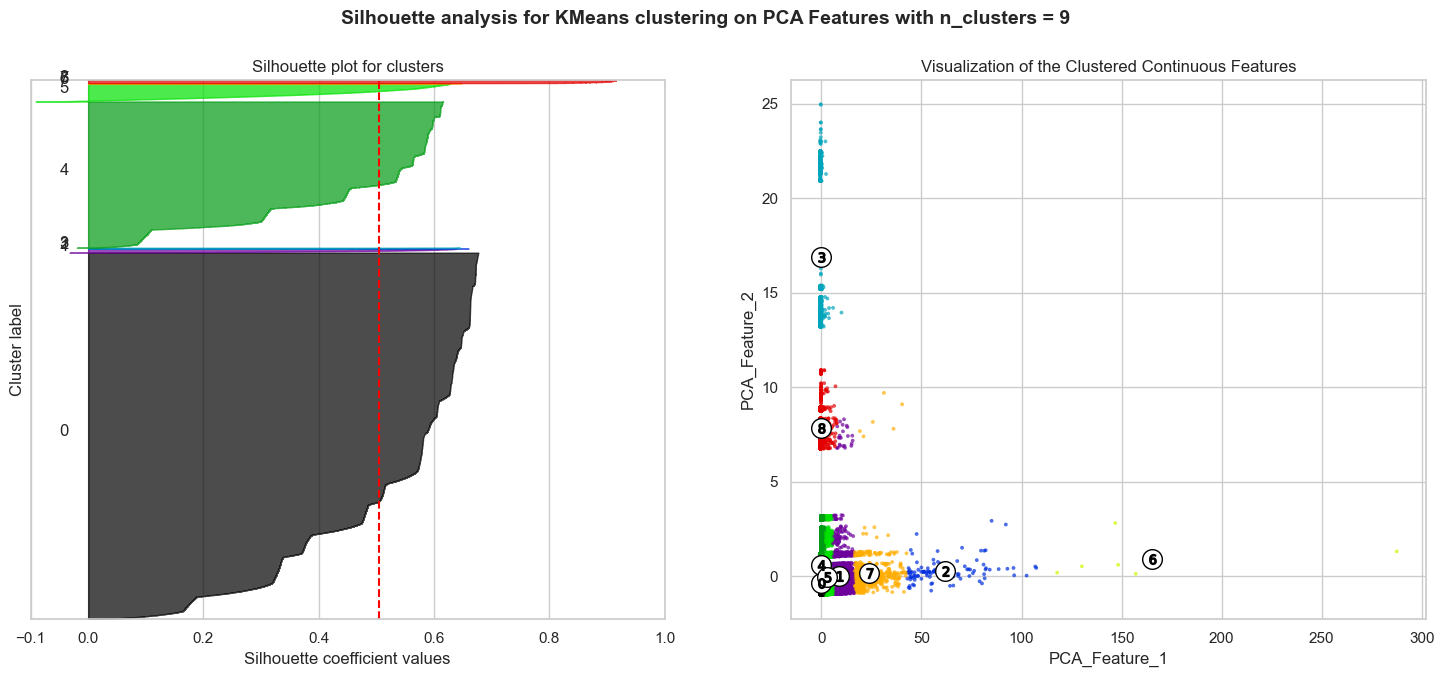

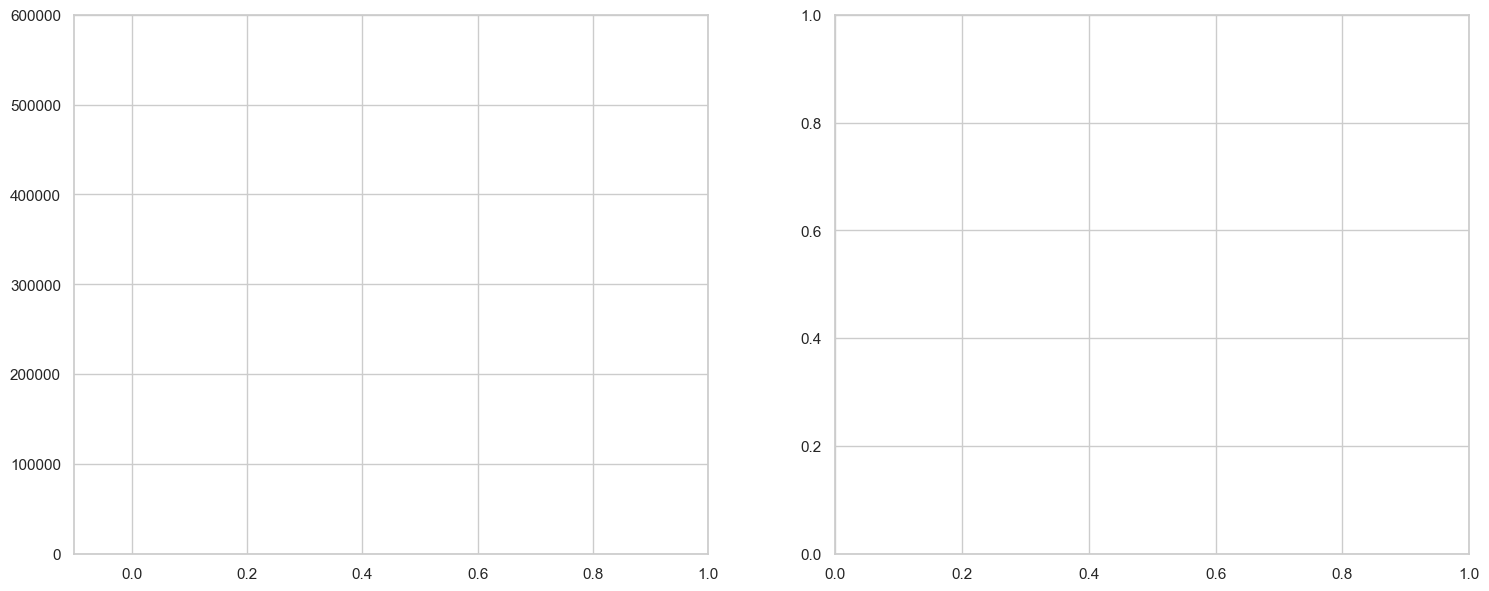

In [10]:
range_n_clusters = [4, 6, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X['PCA_Feature_1'], X['PCA_Feature_2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the Clustered Continuous Features")
    ax2.set_xlabel("PCA_Feature_1")
    ax2.set_ylabel("PCA_Feature_2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on PCA Features with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.savefig("../../data/plots/silhouette_tuning.png")
plt.savefig("../../website-source/silhouette_tuning.png")
plt.show()

### Clustering with 2 clusters

In [11]:
def rename_subreddit(subreddit):
    if subreddit in ("Economics", "finance"):
        return "economics"
    else:
        return "political"

pca_df["subreddit"] = pca_df["subreddit"].apply(rename_subreddit)

X = pca_df.drop("subreddit", axis=1)
y = pca_df["subreddit"]

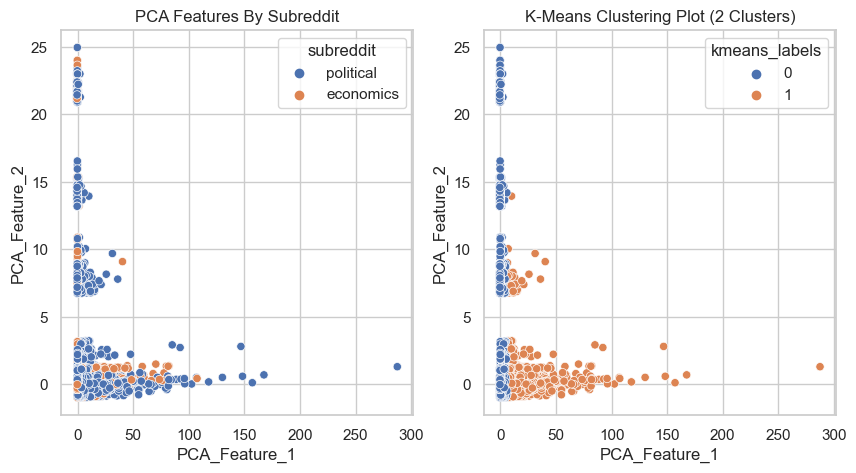

In [13]:
bestK = KMeans(n_clusters=2, init='k-means++', random_state=42)
labels2 = bestK.fit_predict(X)
pca_df['kmeans_labels'] = labels2

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x="PCA_Feature_1", y="PCA_Feature_2", hue="subreddit", data=pca_df, ax=ax[0]).set(title='PCA Features By Subreddit')
sns.scatterplot(x="PCA_Feature_1", y="PCA_Feature_2", hue="kmeans_labels", data=pca_df, ax=ax[1]).set(title='K-Means Clustering Plot (2 Clusters)')
plt.savefig("../../data/plots/kmeans_two_clusters.png")
plt.savefig("../../website-source/kmeans_two_clusters.png")
plt.show()

In [17]:
# silhouette score
silhouette_avg = silhouette_score(X, labels2, sample_size=300000)
print(
    "For n_clusters =",
    2,
    "The average silhouette_score is :",
    silhouette_avg
)

For n_clusters = 2 The average silhouette_score is : 0.9129267595873652
